# This notebook shows how to export a 3D density, calculated with DFT(?), into the simulations class and apply Fourier Transformation.

Uses pymatgen library to read CHGCAR file

In [1]:
import numpy as np
from pyrho.pgrid import PGrid
from pyrho.vis.scatter import get_scatter_plot
from pymatgen.io.vasp import Chgcar
from pyrho.charge_density import ChargeDensity
#API_KEY = open('mp_api.key', 'r').read()

## The next few cells are taken from the pymatgen tutorial. not much thoughts were invested here into understanding the structure of the files, we just want to extract density values

In [2]:
cden_MOF = ChargeDensity.from_file("/home/slaskina/CHGCAR_sum.gz") # read the file with pymathgen.ChargeDensity function

In [3]:

cden_transformed = cden_MOF.get_transformed(
    [[1, 1, 0], [1, -1, 0], [0, 0, 1]],
    grid_out=cden_MOF.grid_shape,
    up_sample=2,
)

In [4]:
data = cden_MOF.normalized_data["total"]
print(
    f"The normalized charge density data is has a range of {data.min():0.3f} --> {data.max():0.3f} e-/Ang^3"
)

The normalized charge density data is has a range of 0.000 --> 53101.355 e-/Ang^3


In [5]:
trans_data = cden_transformed.normalized_data["total"]
print(
    f"The transformed normalized charge density data is has a range of {trans_data.min():0.3f} --> {trans_data.max():0.3f} e-/Ang^3"
)

The transformed normalized charge density data is has a range of 0.000 --> 53101.355 e-/Ang^3


In [6]:
trans_data.shape # the shape of density

(504, 504, 256)

## Now use the simulations class to Fourier Transform the density

In [7]:
from SAXSsimulations import DensityData
from SAXSsimulations.plotting import *

In [8]:
# initialize the empty class with FT functionality and assign pre-calculated density attribute
MOF_sim = DensityData()
MOF_sim.set_density(trans_data)

In [9]:
MOF_sim.pin_memory()

In [10]:
MOF_sim.calculate_custom_FTI_3D_slice(device = 'cuda') # just a central slice

In [11]:
MOF_sim.calculate_custom_FTI_3D(device='cuda') # 3D FT

In [12]:
MOF_sim.calculate_torch_FTI_3D(device='cuda')

In [15]:
np.log(MOF_sim._FTI_custom).min(), np.log(MOF_sim._FTI_custom).max() # calculate teh min/max to establish the colormap boundaries

(tensor(-95.5367, dtype=torch.float64), tensor(-2.1669, dtype=torch.float64))

Show the central slices of the 3D FT in each direction

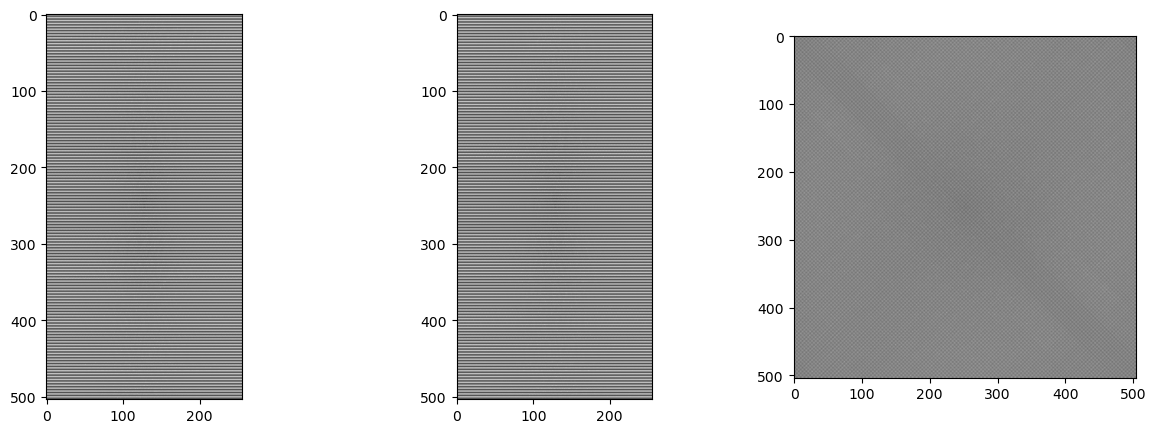

In [16]:
plt_slices_ft(MOF_sim, -100, 0) 

The FT in the direction of z-axis seems to be of interest to us, let's have a closer look

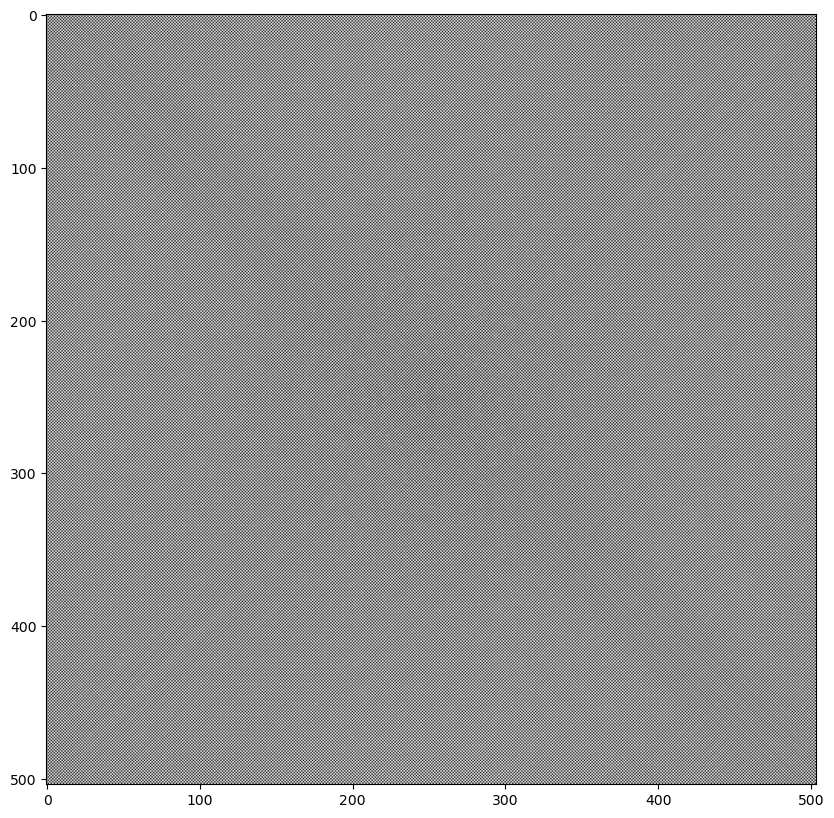

In [17]:
plt.figure(figsize = (10,10))
plt.imshow(np.log(MOF_sim._FTI_custom)[:,:,128], cmap = 'Greys')

For those who fancy HDF format, rewrite the file with most important attributes into the a HDF file:

In [18]:
import h5py
with h5py.File('MOF.h5', "w") as f:
    entry = f.create_group("entry")
    I = entry.create_dataset("nomalized intensity", data=cden_MOF.normalized_data['total'], dtype='f')
    I.attrs['units'] = 'nm-1'
    properties = f.create_group("properties")
    formula = properties.create_dataset('formula', data = cden_MOF.structure.formula)
    grid_shape = properties.create_dataset('grid shape', data = cden_MOF.grid_shape, dtype = 'f')
    lattice = properties.create_dataset('lattice', data = cden_MOF.lattice, dtype = 'f')
    normalization = properties.create_dataset('normalization', data = cden_MOF.normalization)
    pbc = properties.create_dataset('pbc', data = cden_MOF.structure._lattice.pbc)
    volume = properties.create_dataset('volume', data = cden_MOF.structure._lattice.volume)
    angles = properties.create_dataset('angles', data = cden_MOF.structure._lattice.angles)
    sites = f.create_group("sites")
    for i,s in enumerate(cden_MOF.structure._sites):
        group_name = 'atom_' +str(i)
        g = sites.create_group(group_name)
        g.create_dataset('species', data = s.specie.name)
        g.create_dataset('coordinates', data = s.coords, dtype = 'f')
        g.create_dataset('frac_coordinates', data = s.frac_coords, dtype = 'f')

